Name: **Shubham Patil**<br>
Title: **Assignment 5: Implement the Continuous Bag of Words (CBOW) Model.**<br>

# Importing necessary libraries

In [49]:
import matplotlib.pyplot as plt
import numpy as np
# re stands for regular expressions, powerful tool for working with text data.
import re

# A.  Data preparation

In [50]:
#  Define a text containing sentences
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

# Cleaning the data 

In [51]:
# we are passing the  pattern to consider & replace other pattern  with the ' ' inside the sentences input string
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences) #  remove special characters from the sentences

# Removing "one-letter words" and the word appears at the beginning of a sentence.
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [52]:
# Split the text into words after cleaning
words = sentences.split()

# Create a set to store unique words as vocabulary, This step removes duplicate words from the list.
vocab = set(words)

# Get the size of the vocabulary
vocab_size = len(vocab)\



In [53]:
# Define embedding dimension and context size
embed_dim = 10  #  each word will be represented by a vector with 10 numerical values. 
context_size = 2  # model looks at two words on each side of the target word 

Create dictionaries to map words to indices and indices to words


In [54]:
word_to_ix = {word: i for i, word in enumerate(vocab)}  # Map words to indices
# {'apple', 'banana', 'cherry'} = {'apple': 0, 'banana': 1, 'cherry': 2}

ix_to_word = {i: word for i, word in enumerate(vocab)}  # Map indices to words
# {'apple', 'banana', 'cherry'} = {0: 'apple', 1: 'banana', 2: 'cherry}

# B.  Generate training data

In [55]:
# Create a list to store training data, where each entry is a tuple of context words and a target word

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

# -2 ensures that you have a balanced number of words on both sides of the target word

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


# C. Train model


In [56]:
# Initialize random word embeddings for the vocabulary.
# Word embeddings are numerical representations of words that capture their meanings in a multi-dimensional space.
embeddings =  np.random.random_sample((vocab_size, embed_dim)) 

Linear Model

In [57]:
# This function performs a linear transformation on the input matrix m using the weight matrix theta.
def linear(m, theta):
    w = theta
    return m.dot(w)

#multiplying each element in the matrix "m" by the corresponding element in the weight matrix "theta" and 
# then summing up the results to get a new transformed matrix. 

Log softmax + NLLloss = Cross Entropy

A way to quantify how well the model's predictions match the truth in classification problems. 

In [58]:
# log softmax function is used to convert raw scores into probability distributions.
def log_softmax(x):
    e_x = np.exp(x - np.max(x)) #calculates the exponential of each element in the input array x after shifting it by the maximum value in x
    return np.log(e_x / e_x.sum())
# x: The input vector for which log softmax is computed

In [59]:
# Negative Log Likelihood Loss measures how well the model's predicted probabilities match the actual data (target)
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

#  2D array that contains log probabilities or log softmax values produced by a model. 
# targets: This is a 1D array that contains the true class labels for each data point.

In [60]:
# used for calculating the loss for a classification task with logit values (raw scores) as input. 
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits) #  used to create a one-hot encoded representation of the target class.
    out[np.arange(len(logits)),target] = 1 # sets the elements in the out array to 1 for the positions corresponding to the target classes.
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True )# calculates the softmax probabilities for each class
    # axis=-1 typically refers to the last axis.,  keepdims=True means the result will have the same number of dimensions as the original array, but the summed axis will have a size of 1.
    
    return (- out + softmax) / logits.shape[0] # calculates the cross-entropy loss. 

Forward function: The forward function is reponsible for predict the target word based on its context

In [61]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n) # computes the log-softmax of the hidden layer n
    
    return m, n, o

Backward function : used to compute the gradients necessary for updating the model's parameters during the training process.

In [62]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog) # performing a dot product between the transpose of the input word embeddings (m.T) and dlog. 
    
    return dw

Optimize function : It is used to updates the parameters by moving them in the direction that reduces the loss (as indicated by the negative gradients) and returns the updated parameters.

In [63]:
def optimize(theta, grad, learning_rate=0.03): # 0.3 step size for the parameter updates.
    theta -= grad *  learning_rate
    return theta

# Training 

In [17]:
# Generate random initial weights for the linear transformation
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size)) # This expression represents the total number of parameters in the weight matrix

In [66]:
# An epoch is one complete pass through the entire training dataset.

epoch_losses = {} # an empty dictionary to store the losses for each epoch.

for epoch in range(80):

    losses =  [] # used to calculate and store the losses for each data point during the epoch.

    for context, target in data:
        # It takes each word in the context list, looks up its corresponding numerical index in the word_to_ix mapping, and creates an array of numerical indices.
        context_idxs = np.array([word_to_ix[w] for w in context])
        
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]]) # target word is converted into its numerical index.
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad,learning_rate=0.03)
        
     
    epoch_losses[epoch] = losses 
    # the list of losses for that epoch is stored in the epoch_losses dictionary with the current epoch number as the key.

# Ploting the  loss per epoch

Text(0, 0.5, 'Losses')

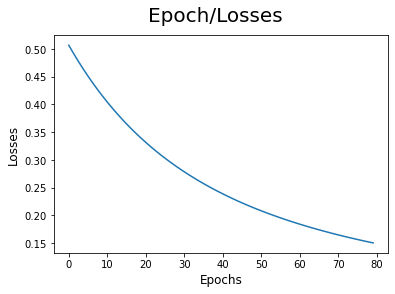

In [67]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [68]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words]) #  converting a list of input words (words) into numerical indices 
    preds = forward(context_idxs, theta) # computes the model's predictions based on the provided context. 
    word = ix_to_word[np.argmax(preds[-1])] # accesses the last element (last prediction) in the preds array. 
    
    return word

In [69]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

Accuracy

In [70]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [71]:
accuracy()

1.0

In [72]:
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'